# Traitement naturel du language
## Création d'un RNN pour la classification de phrases en six émotions

----------------------

In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt

In [2]:
%autoreload 2
from RNN import *
from data_processing import *

#### Chargement des données

In [3]:
text, emotion = load_file("./dataset/train.txt")

print(text[2])
print(tokenizer(text[2]))
print(emotion[2])

im grabbing a minute to post i feel greedy wrong
['im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']
anger


#### Création de l'ensemble de mots 
1. Lister tous les tokens

In [4]:
lst = list(yield_tokens(text))
print(lst[:50])
print(lst[-50:])

['i', 'didnt', 'feel', 'humiliated', 'i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', 'i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still']
['i', 'feel', 'pathetic', 'that', 'i', 'am', 'still', 'waiting', 'tables', 'and', 'subbing', 'with', 'a', 'teaching', 'degree', 'i', 'feel', 'strong', 'and', 'good', 'overall', 'i', 'feel', 'like', 'this', 'was', 'such', 'a', 'rude', 'comment', 'and', 'im', 'glad', 'that', 't', 'i', 'know', 'a', 'lot', 'but', 'i', 'feel', 'so', 'stupid', 'because', 'i', 'can', 'not', 'portray', 'it']


2. Associer à chaque mot une valeur unique (entier positif) **pas de doublon**

In [5]:
vocab = build_vocab_from_iterator(lst, specials=["<pad>", "<unk>"])
print(len(vocab))
print(vocab["i"])
print(vocab["didnt"])
print(vocab["feel"])
print(vocab["<pad>"])
print(vocab["<unk>"])

15214
2
3
4
0
1


#### Faire pareil avec les émotions, qui représentent les classes

In [6]:
classes = build_vocab_from_iterator(yield_tokens(emotion))
print(len(classes))
print(classes["anger"])

6
1


#### Coder une phrase 
1. Représenter une phrase comme une suite de valeurs

In [7]:
print(text[1])
codage_entier_phrase = [vocab[word] for word in tokenizer(text[1])]
print(codage_entier_phrase)

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[2, 6, 7, 8, 9, 10, 11, 12, 10, 13, 14, 15, 8, 16, 17, 18, 19, 20, 21, 22, 23]


2. Représenter chaque phrase comme un tensor d'entiers **seulement à partir de cette étape, on utiliser la librairie pytorch**

In [8]:
tensor_entier = torch.tensor(codage_entier_phrase)
print(tensor_entier)

tensor([ 2,  6,  7,  8,  9, 10, 11, 12, 10, 13, 14, 15,  8, 16, 17, 18, 19, 20,
        21, 22, 23])


3. Représenter chaque phrase comme un tensor one hot **attention, il peut être difficile de charger en mémoire l'ensemble du dataset sous la forme on-hot, privilégier si besoin la génération one-hot par batch, en utilisant un Dataloader**

In [9]:
tensor_one_hot = torch.nn.functional.one_hot(tensor_entier, num_classes=len(vocab))
print(tensor_one_hot)

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


4. Ensuite : 
- Finaliser le codage : 
    - rogner ou compléter les phrase (*pad*) : longeur identique en entrée du réseau quelque soit la phrase 
    - optimiser : *unk* pour les mots sous représentés 
    - préparer le réseau 
    - entrainer le réseau sur la classification des émotions 
    - optimiser, analyser les résultats 
    - entrainer le réseau de façon autosupervisée : prédiction du mots suivant à partir de mots précédents par exemple 
    - analyser l'embeding

#### Rogner ou compléter les phrases

(array([2641., 3795., 3968., 2306., 1499.,  963.,  453.,  251.,  106.,
          18.]),
 array([ 2. ,  8.4, 14.8, 21.2, 27.6, 34. , 40.4, 46.8, 53.2, 59.6, 66. ]),
 <BarContainer object of 10 artists>)

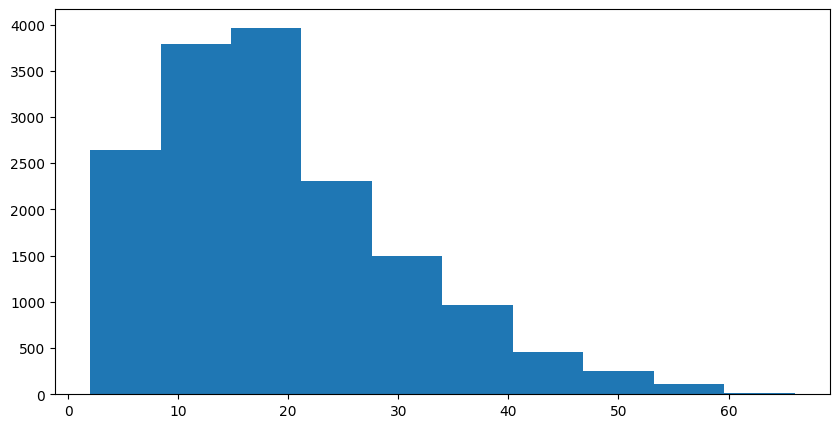

In [10]:
"""sentences_lenght = {}
for sentence in text:
    size = len(sentence)
    sentences_lenght[size] = sentences_lenght.get(size, 0) + 1"""

sentences_lenght = [len(sentence.split(" ")) for sentence in text]

plt.figure(figsize=(10,5))
plt.hist(sentences_lenght)

Au vue de la distribution de la taille des phrases, on peut considérer que ne garder que les phrases de taille inférieure à 20 sera déjà un bon départ pour le réseau

In [11]:
size_threshold = 20
lst = list(yield_tokens(text, threshold=size_threshold))
print(lst[:50])
print(len(lst))

['i', 'didnt', 'feel', 'humiliated', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will']
197880


#### Unknown pour les mots sous-représentés

In [12]:
appearance_threshold = 3
lst_with_unk = yield_tokens_with_unknown(lst, threshold=appearance_threshold)
lst_with_unk

['i',
 'didnt',
 'feel',
 'humiliated',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'im',
 '<unk>',
 'a',
 'minute',
 'to',
 'post',
 'i',
 'feel',
 'greedy',
 'wrong',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'i',
 'am',
 'ever',
 'feeling',
 'nostalgic',
 'about',
 'the',
 '<unk>',
 'i',
 'will',
 'know',
 'that',
 'it',
 'is',
 'still',
 'on',
 'the',
 '<unk>',
 '<pad>',
 '<pad>',
 'i',
 'am',
 'feeling',
 'grouchy',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'ive',
 'been',
 'feeling',
 'a',
 'little',
 'burdened',
 'lately',
 'wasnt',
 'sure',
 'why',
 'that',
 'was',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'i',
 'feel',
 'as',
 'confused',
 'about',


#### Préparer le réseau

1. Batch des données de train (DataLoader)

In [3]:
# parameters for filtering the vocabulary
size_threshold = 20
appearance_threshold = 3

In [4]:
# load text and emotion data for training, validation and test sets
text_train, emotion_train = load_file("./dataset/train.txt")
text_validation , emotion_validation = load_file("./dataset/val.txt")
text_test, emotion_test = load_file("./dataset/test.txt")

# build vocabulary for each set
lst_train_with_unk = list(yield_tokens_with_unknown(list(yield_tokens(text_train, threshold=size_threshold)), 
                                                    threshold=appearance_threshold))
vocab_train = build_vocab_from_iterator(lst_train_with_unk, specials=["<pad>", "<unk>"])

lst_val = list(yield_tokens(text_validation, threshold=size_threshold)) # we do not add <unk> in the validation and test sets, we just replace unknown words (not in the train set) by <unk>
lst_test = list(yield_tokens(text_test, threshold=size_threshold))

# convert to OneHotEncoder dataset
nb_train_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_train)
nb_validation_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_validation)
nb_test_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_test)

print(f"Number of training sentences: {nb_train_sentences}, vocab size: {len(vocab_train)}")
print(f"Number of validation sentences: {nb_validation_sentences}")
print(f"Number of test sentences: {nb_test_sentences}")

Number of training sentences: 9894, vocab size: 2098
Number of validation sentences: 1262
Number of test sentences: 1230


In [5]:
# keep only emotion from sentences of length <= size_threshold
emotion_train = [emotion_train[i] for i in range(len(text_train)) if len(text_train[i].split(" "))<=size_threshold]
emotion_validation = [emotion_validation[i] for i in range(len(text_validation)) if len(text_validation[i].split(" "))<=size_threshold]
emotion_test = [emotion_test[i] for i in range(len(text_test)) if len(text_test[i].split(" "))<=size_threshold]

lst_train_emotion = list(yield_tokens(emotion_train))
emotion_classes = build_vocab_from_iterator(lst_train_emotion) # we build the emotion classes only with the training set

lst_val_emotion = list(yield_tokens(emotion_validation))
lst_test_emotion = list(yield_tokens(emotion_test))

In [6]:
train_dataset = EmotionsDataset(tokenized_text=lst_train_with_unk, 
                              vocab=vocab_train, 
                              nb_sentences=nb_train_sentences, 
                              tokenized_emotion=lst_train_emotion, 
                              emotion_classes=emotion_classes)
validation_dataset = EmotionsDataset(tokenized_text=lst_val, 
                                    vocab=vocab_train, 
                                    nb_sentences=nb_validation_sentences, 
                                    tokenized_emotion=lst_val_emotion, 
                                    emotion_classes=emotion_classes)
test_dataset = EmotionsDataset(tokenized_text=lst_test, 
                              vocab=vocab_train, 
                              nb_sentences=nb_test_sentences, 
                              tokenized_emotion=lst_test_emotion, 
                              emotion_classes=emotion_classes)

In [7]:
print("First sentence of the training set (text):")
print(text_train[0])
print("Associated emotion:", emotion_train[0])
print("First sentence of the training set (one-hot encoded):")
print(train_dataset[0])

First sentence of the training set (text):
i didnt feel humiliated
Associated emotion: sadness
First sentence of the training set (one-hot encoded):
(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]), tensor([1., 0., 0., 0., 0., 0.]))


Le réseau de neurone prend en entrée de façon récurrente un vecteur : $(batch_{size},vocab_{size})$. Soit par exemple pour un $batch_{size} = 10$, $sentence_{size} = 20$ :
 les dix premiers mots, les dix seconds mots, ..., les dix vingtièmes mots

2. Création du modèle

In [8]:
# hyperparameters definition
emb_size = 64 # arbitrary choice
hidden_size = 128 # arbitrary choice
rnn_layers = 1

eta = 1e-3
n_epochs=50

In [9]:
device = "xpu" if torch.xpu.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = ElmanRNN(input_size=len(vocab_train),hidden_size=hidden_size,emb_size=emb_size,output_size=len(emotion_classes),num_layers=rnn_layers, device=device).to(device)
print(model)

Using xpu device
ElmanRNN(
  (i2e): Linear(in_features=2098, out_features=64, bias=True)
  (i2h): Linear(in_features=192, out_features=128, bias=True)
  (i2o): Linear(in_features=192, out_features=6, bias=True)
)


In [10]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=eta) # trouver la méthode pour faire un équilibrage des classes dans un second temps

3. Test du modèle (sans/avec récurrence, phrase unique/batch)

In [11]:
# Test with no recurrence (single word to predict the emotion, batch_size=1)
batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_train))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))

batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    X, y, lengths = batch
    pred, _ = model.forward_sequence(X.to(device), lengths=lengths.to(device), recurrence=False)
    pred = torch.nn.functional.log_softmax(pred, dim=1)
    for prediction, target in zip(pred, y):
        print(prediction, target)

tensor([-1.7548, -1.7721, -1.7480, -1.8273, -1.8295, -1.8225], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])


In [12]:
# Test of the network, calling it with recurrence (batch_size=1)
batch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_train))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))

batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    X, y, lengths = batch
    pred, _ = model.forward_sequence(X.to(device), lengths=lengths.to(device), recurrence=True)
    pred = torch.nn.functional.log_softmax(pred, dim=1)
    for prediction, target in zip(pred, y):
        print(prediction, target)

tensor([-1.7711, -1.7449, -1.7417, -1.8440, -1.7919, -1.8634], device='xpu:0') tensor([0., 0., 0., 0., 1., 0.])


In [13]:
# Test of the network, calling it with recurrence (batch_size>1)
batch_size = 10

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, vocab_train))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: collate_fn(x, vocab_train))

batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    X, y, lengths = batch
    pred, _ = model.forward_sequence(X.to(device), lengths=lengths.to(device), recurrence=True)
    pred = torch.nn.functional.log_softmax(pred, dim=1)
    for prediction, target in zip(pred, y):
        print(prediction, target)

tensor([-1.7555, -1.7445, -1.7488, -1.8387, -1.7967, -1.8734], device='xpu:0') tensor([0., 1., 0., 0., 0., 0.])
tensor([-1.7606, -1.7444, -1.7439, -1.8403, -1.7988, -1.8696], device='xpu:0') tensor([0., 0., 0., 1., 0., 0.])
tensor([-1.7636, -1.7463, -1.7428, -1.8288, -1.7991, -1.8768], device='xpu:0') tensor([0., 1., 0., 0., 0., 0.])
tensor([-1.7647, -1.7460, -1.7341, -1.8492, -1.8039, -1.8598], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7637, -1.7507, -1.7382, -1.8357, -1.7954, -1.8739], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7679, -1.7420, -1.7373, -1.8387, -1.7978, -1.8744], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7604, -1.7441, -1.7415, -1.8465, -1.7984, -1.8669], device='xpu:0') tensor([1., 0., 0., 0., 0., 0.])
tensor([-1.7641, -1.7420, -1.7460, -1.8445, -1.7923, -1.8687], device='xpu:0') tensor([0., 0., 0., 1., 0., 0.])
tensor([-1.7640, -1.7412, -1.7459, -1.8383, -1.8013, -1.8665], device='xpu:0') tensor([0., 1., 0., 0., 0

#### Entrainer le réseau sur la classification des émotions

In [ ]:
# -------------------------
# 7) Pipeline
# -------------------------
def run_pipeline(train_path: str, val_path: str, test_path: str,
                 sep: str = ";",
                 specials: list[str] = ["<pad>", "<unk>"],
                 min_freq: int = 1,
                 batch_size: int = 64,
                 hidden_size: int = 128,
                 n_epochs: int = 20,
                 lr: float = 1e-3,
                 device = None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # 1) load
    train_texts, train_labels = load_file(train_path, sep=sep)
    val_texts, val_labels = load_file(val_path, sep=sep)
    test_texts, test_labels = load_file(test_path, sep=sep)

    # Check if datasets are empty
    if not train_texts or not train_labels:
        print(f"Error: Training data is empty after loading from {train_path}. Please check the file path and separator.")
        return None, None, None, None, None # Return None for all outputs
    if not val_texts or not val_labels:
        print(f"Error: Validation data is empty after loading from {val_path}. Please check the file path and separator.")
        return None, None, None, None, None # Return None for all outputs
    if not test_texts or not test_labels:
        print(f"Error: Test data is empty after loading from {test_path}. Please check the file path and separator.")
        return None, None, None, None, None # Return None for all outputs


    # 2) vocab
    # tokens iterator uses only train
    voc = build_vocab_from_iterator(yield_tokens(train_texts), specials=specials)
    print("Vocab size:", len(voc))
    # reverse mapping
    itos = {idx: token for token, idx in voc.items()}

    # classes vocab
    classes = build_vocab_from_iterator(yield_tokens(train_labels), specials=[])
    label2idx = {lab: idx for lab, idx in classes.items()}
    idx2label = {v:k for k,v in label2idx.items()}
    print("Num classes:", len(label2idx), "classes:", list(label2idx.keys()))

    # 3) datasets + loaders
    train_ds = EmotionsDataset(train_texts, train_labels, voc, label2idx)
    val_ds = EmotionsDataset(val_texts, val_labels, voc, label2idx)
    test_ds = EmotionsDataset(test_texts, test_labels, voc, label2idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pad)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)

    # 4) model
    vocab_size = len(voc)
    num_classes = len(label2idx)
    model = ElmanRNN(input_size=vocab_size, hidden_size=hidden_size, output_size=num_classes, device=device).to(device)

    # 5) class weights
    class_weights = compute_class_weights(train_labels, label2idx).to(device)
    # We'll handle potential zero weight (class not present) by replacing zeros with 0.0
    class_weights[class_weights == 0.0] = 0.0
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 6) train loop with early stopping
    best_val_acc = 0.0
    patience = 0
    early_stop = 5
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_path = "best_elman_rnn.pt"

    for epoch in range(1, n_epochs + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion, device)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            torch.save(model.state_dict(), best_path)
            print("  -> saved model")
        else:
            patience += 1
            if patience >= early_stop:
                print("Early stop")
                break

    # load best model
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, y_true, y_pred = eval_epoch(model, test_loader, criterion, device)
    print(f"Test loss {test_loss:.4f} acc {test_acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=[idx2label[i] for i in range(len(idx2label))]))

    # Visualisations demandées
    plot_learning(history)
    plot_confusion(y_true, y_pred, [idx2label[i] for i in range(len(idx2label))])

    # Embedding matrix - ici l'embedding est implicite : la "matrice d'embedding"
    # correspond à la matrice de poids de i2h / i2o si on voulait en extraire
    # Ici on peut extraire les colonnes correspondantes en simulant une one-hot for each token:
    # For token i, combined = [one_hot(i), zeros(hidden)] so i2h.weight[:, :vocab_size] acts like embedding
    with torch.no_grad():
        # i2h weight shape: (hidden_size, input_size + hidden_size)
        w_i2h = model.i2h.weight[:, :vocab_size].cpu().numpy().T  # (vocab_size, hidden_size)
        # optionally reduce dim to visualize
        visualize_embeddings_pca_tsne(w_i2h, itos, top_n=200)

    return model, voc, itos, label2idx, history

In [28]:
batch_size = 10

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [29]:
best_score = 0
counter = 0
train_losses, val_losses = [], [] # to store the losses for plotting later
# writer = torch.utils.tensorboard.SummaryWriter()
for t in range(n_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_func, optim, device, recurrence=True)
    val_accuracy, val_loss = test(validation_loader, model, loss_func, device, recurrence=True)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    stop, best_score, counter = early_stopping(best_score, val_accuracy, threshold=0.001, patience=5, counter=counter)
    if stop:
        break

    # writer.add_scalar('Loss/train', train_loss, t)
    # writer.add_scalar('Loss/validation', val_loss, t)
    # writer.add_scalar('Accuracy/validation', val_accuracy, t)

print(f"Best validation accuracy reached: {best_score*100:>0.1f}%, after {t+1} epochs")

# visualize the training curves with tensorboard
# writer.flush()
# writer.close()
# tensorboard --logdir=runs (launch this command in the terminal)

# visualize the training and validation loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1
-------------------------------
loss: 1.804481  [   10/ 9894]
loss: 1.538822  [ 1010/ 9894]
loss: 1.601116  [ 2010/ 9894]
loss: 1.574642  [ 3010/ 9894]
loss: 1.339141  [ 4010/ 9894]
loss: 1.844930  [ 5010/ 9894]
loss: 1.358010  [ 6010/ 9894]
loss: 1.369007  [ 7010/ 9894]
loss: 1.370254  [ 8010/ 9894]
loss: 1.572130  [ 9010/ 9894]
Test Error: 
 Accuracy: 34.9%, Avg loss: 1.587962 

Epoch 2
-------------------------------
loss: 1.400554  [   10/ 9894]
loss: 1.558860  [ 1010/ 9894]
loss: 1.406812  [ 2010/ 9894]
loss: 1.690402  [ 3010/ 9894]
loss: 1.380904  [ 4010/ 9894]
loss: 1.558254  [ 5010/ 9894]
loss: 1.616880  [ 6010/ 9894]
loss: 1.482635  [ 7010/ 9894]
loss: 1.263819  [ 8010/ 9894]
loss: 1.685166  [ 9010/ 9894]
Test Error: 
 Accuracy: 34.6%, Avg loss: 1.585503 

Epoch 3
-------------------------------
loss: 1.410831  [   10/ 9894]
loss: 1.634604  [ 1010/ 9894]
loss: 1.789904  [ 2010/ 9894]
loss: 1.749041  [ 3010/ 9894]
loss: 1.780067  [ 4010/ 9894]
loss: 1.462513  [ 5010/ 98

KeyboardInterrupt: 

In [ ]:
# add computation of confusion matrix (to be done)

In [ ]:
# hyperparameters tuning (to be done)

#### Optimiser, analyser les résultats

In [ ]:
# limiter l'effet du déséquilibre des classes (loss adaptée)
# changer le threshold de filtrage des mots rares

#### Approfondissement

In [ ]:
# matrice d'embedding : observer la représentation des mots dans l'espace des embeddings

In [ ]:
# apprentissage auto-supervisé des embeddings (word2vec, GloVe, FastText)